In [560]:
from pandas import read_csv
from fmritools.design import design_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from statsmodels.stats.outliers_influence import variance_inflation_factor

from nilearn import plotting
from nilearn.image import mean_img

from nibabel import Nifti1Image

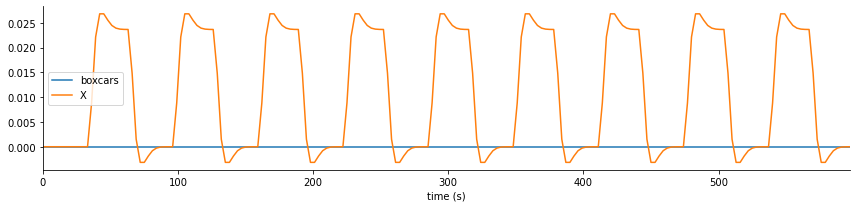

In [572]:
# Define some acquisition parameters
n_acq = 200
tr = 3

# Load experimental events
subject = 'sub-395'
events_f = f'./ds002799/{subject}/ses-postop/func/{subject}_ses-postop_task-es_run-02_events.tsv'
events = read_csv(events_f, sep='\t')

# Limit only to checkerboard events
# events = events.query('event=="Checkerboard"')
# events.event = 1

# Compute offsets (onset + duration)
events['offset'] = events['onset'].values + events['duration'].values

# Construct events matrix
events = events[['onset','offset']].values
events = np.hstack((events, np.ones((events.shape[0], 1))))

# Define design matrix
times, X, boxcars = design_matrix(tr, n_acq, events, return_boxcars=True)

# Plot boxcars
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.plot(times, boxcars, label='boxcars')
ax.plot(times, X, label='X')
ax.set(xlim=(times.min(), times.max()), xlabel='time (s)')
ax.legend()
sns.despine()
plt.tight_layout()

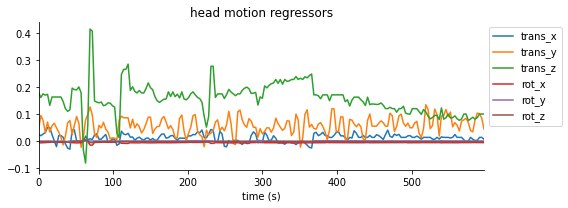

In [573]:
# Load fMRIPrep confound regressors
confounds_f = f'./ds002799/derivatives/fmriprep/{subject}/ses-postop/func/{subject}_ses-postop_task-es_run-02_desc-confounds_regressors.tsv'
confounds = read_csv(confounds_f, sep='\t')

# Extract motion regressors
motion_labels = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
motion = confounds[motion_labels].values

# Visualize motion regressors
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(times, motion[:n_acq], label=motion_labels)
ax.set(xlim=(times.min(), times.max()), xlabel='time (s)', 
       title='head motion regressors')
plt.legend(bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout()

7 bad volumes detected


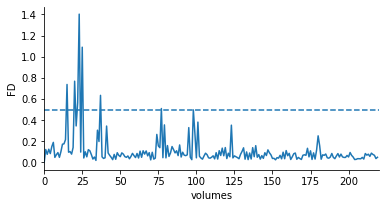

In [574]:
# Define FD threshold
fd_threshold = 0.5

# Extract framewise displacement from confounds table
fd = confounds['framewise_displacement'].values
fd[np.isnan(fd)] = 0

# Identify infected volumes
bad_vols = np.argwhere(fd >= fd_threshold)
print(f'{bad_vols.size} bad volumes detected')

# Construct censor regressors
censors = np.zeros((fd.shape[0], bad_vols.shape[0]))
censors[bad_vols.T, np.arange(bad_vols.shape[0])] = 1
censor_labels = [f'censor{c}' for c in np.arange(censors.shape[1])]

# Visualize framewise displacement time series
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(fd)
ax.hlines(fd_threshold, 0, fd.size, linestyle='--')
ax.set(xlim=(0, fd.size), xlabel='volumes', ylabel='FD')
sns.despine()

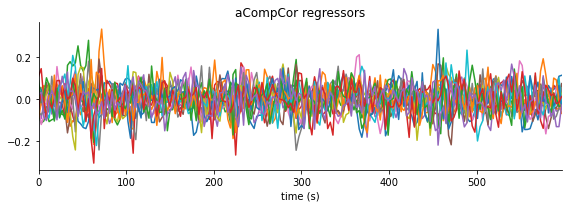

In [575]:
# Extract aCompCor signals from confounds table
acompcor_n = 15
acompcor_df = confounds.filter(regex='a_comp_cor_').iloc[:, :acompcor_n]
acompcor_labels = acompcor_df.columns.tolist()
acompcor = acompcor_df.values

# Plot aCompCor regressors
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(times, acompcor[:n_acq, :])
ax.set(xlim=(times.min(), times.max()), xlabel='time (s)', 
       title='aCompCor regressors')
sns.despine()
plt.tight_layout()

In [576]:
# Column-stack nuisance regressors into one confound matrix. Include intercept term
# Define intercept
intercept = np.ones(n_acq)

# Stack nuisance regressors
Z = np.column_stack([intercept, motion[:n_acq], censors[:n_acq], acompcor[:n_acq]])

# Keep track of confound labels
confound_labels = ['intercept'] + motion_labels + censor_labels + acompcor_labels

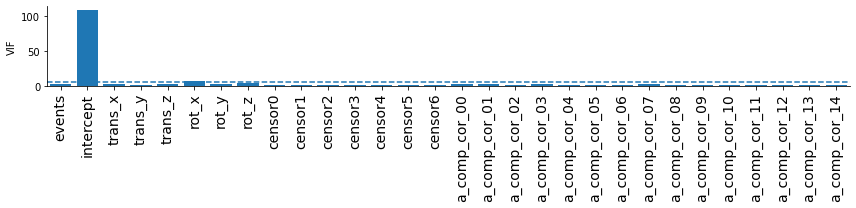

In [577]:
# Check collinearity
# Assemble all regressors (experimental + confound)
XZ = np.column_stack([X, Z])

# Assemble all regressor labels
regressor_labels = ['events'] + confound_labels

# Check variance inflation factor
vif = [variance_inflation_factor(XZ, i) for i in range(XZ.shape[-1])]

# Visualize collinearity
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.bar(np.arange(len(vif)), vif)
ax.hlines(5,-0.5,len(vif)-0.5,linestyle='--')
ax.set(xlim=(-0.5,len(vif)-0.5), xticks=np.arange(len(vif)), 
       ylabel='VIF')
ax.set_xticklabels(regressor_labels, rotation=90, fontsize=14)
sns.despine()
plt.tight_layout()

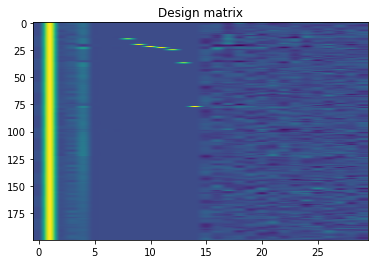

In [583]:
plt.imshow(XZ, aspect='auto')
plt.title('Design matrix')
plt.show()

In [579]:
# load and mask data
bold_f = f'./derivatives/fmriprep/{subject}/ses-postop/func/{subject}_ses-postop_task-es_run-02_space-T1w_desc-preproc_bold.nii.gz'
bold_img = nib.load(bold_f)
bold = bold_img.get_fdata()
print(f'Functional data shape: {bold.shape}')

# Load anatomical segmentation
f = f'./derivatives/fmriprep/{subject}/ses-postop/func/{subject}_ses-postop_task-es_run-02_space-T1w_desc-aseg_dseg.nii.gz'
aseg = nib.load(f).get_fdata()
print(f'Segmentation shape: {aseg.shape}')

# Store dimensions of anatomical image
brain_shape = aseg.shape

# Store indices corresponding to gray matter mask
# Cortex
mask_img = nib.Nifti1Image(np.logical_or(aseg == 3,     # left cortex
                                         aseg == 42).astype(float),
                           affine=bold_img.affine)    # right cortex
mask_indices = np.where(np.logical_or(aseg == 3,    # left cortex
                                      aseg == 42    # right cortex
                                      ))
# Thalamus
# mask_img = nib.Nifti1Image(np.logical_or(aseg == 10,     # left thalamus
#                                          aseg == 49).astype(float),
#                            affine=bold_img.affine)    # right cortex
# mask_indices = np.where(np.logical_or(aseg == 10,    # left thalamus
#                                       aseg == 49    # right thalamus
#                                       ))

# Brainstem
# mask_img = nib.Nifti1Image((aseg == 16).astype(float),
#                            affine=bold_img.affine)    
# mask_indices = np.where((aseg == 10))


# Apply gray matter mask
bold_masked = bold[mask_indices]

# Transpose data to shape (n_times, n_voxels)
Y = bold_masked.T
print(f'Masked data shape: {Y.shape}')

Functional data shape: (43, 53, 45, 220)
Segmentation shape: (43, 53, 45)
Masked data shape: (220, 12875)


mean EPI shape:  (43, 53, 45, 220)


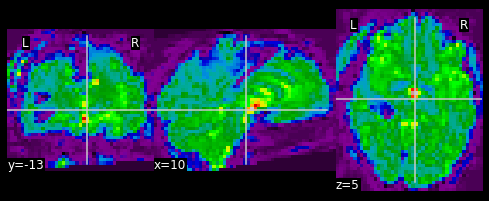

In [580]:
# Plot average activation
mean_data = mean_img(bold_img)
print("mean EPI shape: ", bold_img.shape)
plotting.plot_epi(mean_data)
plt.show()

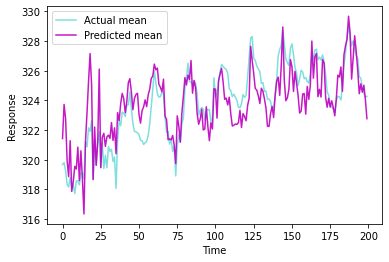

In [581]:
# Run regression with basic OLS
b, _, _, _ = np.linalg.lstsq(XZ, Y[:n_acq], rcond=-1)

# Check OLS results
Ypred = XZ @ b
plt.plot(np.mean(Y[:n_acq], axis=1), 'c', alpha=0.5, label='Actual mean')
plt.plot(np.mean(Ypred, axis=1), 'm', alpha=0.9, label='Predicted mean')
plt.xlabel('Time')
plt.ylabel('Response')
plt.legend()
plt.show()

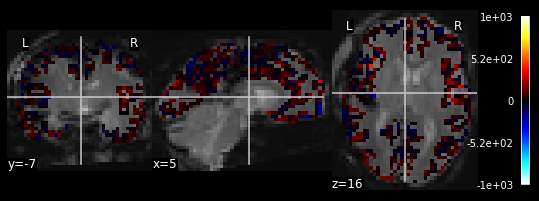

In [582]:
# Plot beta coefficients for the events regressor on the brain here:
b_regressor = b[regressor_labels.index('events')] 
beta_map = np.zeros_like(bold_img.get_fdata()[:,:,:,0])
beta_map[mask_indices] = b_regressor

plotting.plot_stat_map(Nifti1Image(beta_map, bold_img.affine), mean_data)
# plt.savefig(f'./activation_regions/{subject}.png')
plt.show()